In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def measure_rt60(h, fs=1, decay_db=60, plot=False, rt60_tgt=None):
    """
    Analyze the RT60 of an impulse response. Optionaly plots some useful information.
    Parameters
    ----------
    h: array_like
        The impulse response.
    fs: float or int, optional
        The sampling frequency of h (default to 1, i.e., samples).
    decay_db: float or int, optional
        The decay in decibels for which we actually estimate the time. Although
        we would like to estimate the RT60, it might not be practical. Instead,
        we measure the RT20 or RT30 and extrapolate to RT60.
    plot: bool, optional
        If set to ``True``, the power decay and different estimated values will
        be plotted (default False).
    rt60_tgt: float
        This parameter can be used to indicate a target RT60 to which we want
        to compare the estimated value.
    """

    h = np.array(h)
    fs = float(fs)

    # The power of the impulse response in dB
    power = h**2
    energy = np.cumsum(power[::-1])[::-1]  # Integration according to Schroeder

    # remove the possibly all zero tail
    i_nz = np.max(np.where(energy > 0)[0])
    energy = energy[:i_nz]
    energy_db = 10 * np.log10(energy)
    energy_db -= energy_db[0]

    # -5 dB headroom
    i_5db = np.min(np.where(-5 - energy_db > 0)[0])
    e_5db = energy_db[i_5db]
    t_5db = i_5db / fs

    # after decay
    i_decay = np.min(np.where(-5 - decay_db - energy_db > 0)[0])
    t_decay = i_decay / fs

    # compute the decay time
    decay_time = t_decay - t_5db
    est_rt60 = (60 / decay_db) * decay_time

    if plot:
        import matplotlib.pyplot as plt

        # Remove clip power below to minimum energy (for plotting purpose mostly)
        energy_min = energy[-1]
        energy_db_min = energy_db[-1]
        power[power < energy[-1]] = energy_min
        power_db = 10 * np.log10(power)
        power_db -= np.max(power_db)

        # time vector
        def get_time(x, fs):
            return np.arange(x.shape[0]) / fs - i_5db / fs

        T = get_time(power_db, fs)

        # plot power and energy
        plt.plot(get_time(energy_db, fs), energy_db, label="Energy")

        # now the linear fit
        plt.plot([0, est_rt60], [e_5db, -65], "--", label="Linear Fit")
        plt.plot(T, np.ones_like(T) * -60, "--", label="-60 dB")
        plt.vlines(
            est_rt60, energy_db_min, 0, linestyles="dashed", label="Estimated RT60"
        )

        if rt60_tgt is not None:
            plt.vlines(rt60_tgt, energy_db_min, 0, label="Target RT60")

        plt.legend()

    return est_rt60

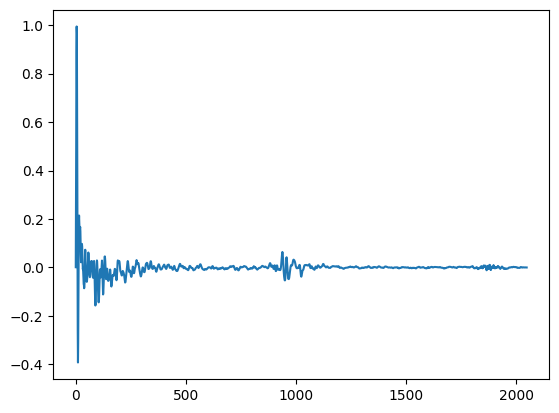

0.042125


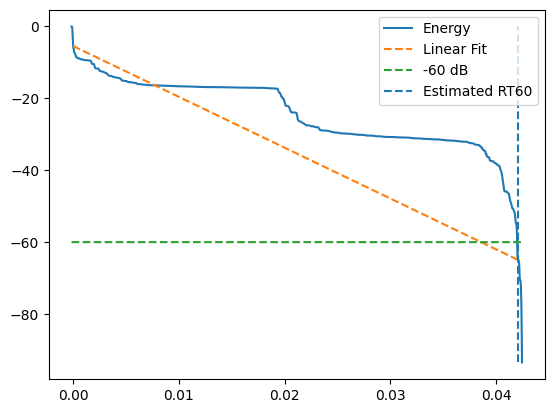

In [3]:
raw = open("impedance_2.dat")
impedance = []
for element in raw.readlines():
    impedance.append(float(element.strip()[:-1]))

plt.plot(impedance)
plt.show()

est_rt60 = measure_rt60(impedance, fs=48000, plot=True)
print(est_rt60)